In [1]:
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import ast
from sklearn.model_selection import train_test_split
import seaborn as sns

In [2]:
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

In [3]:
def plot_the_loss_curve(epochs, mse_training, mse_validation):

  plt.figure()
  plt.xlabel("Epoch")
  plt.ylabel("Loss")

  plt.plot(epochs[0:], mse_training[0:], label="Training Loss")
  plt.plot(epochs[0:], mse_validation[0:], label="Validation Loss")
  plt.legend()
  
  # We're not going to plot the first epoch, since the loss on the first epoch
  # is often substantially greater than the loss for other epochs.
  merged_mse_lists = mse_training[1:] + mse_validation[1:]
  highest_loss = max(merged_mse_lists)
  lowest_loss = min(merged_mse_lists)
  delta = highest_loss - lowest_loss
  print(delta)

  top_of_y_axis = highest_loss + (delta * 0.05)
  bottom_of_y_axis = lowest_loss - (delta * 0.05)
   
  plt.ylim([bottom_of_y_axis, top_of_y_axis])
  plt.show() 

In [4]:
l_min = 1
l_max = 1

n_l = 1  # defined only one value for L, for now.

# q in kN
q_min = 100
q_max = 500

n_q = 80

# E in GPa
E_min = 100
E_max = 350

n_E = 80

# I in dm^4
I_min = 1 * 10 ** 3 
I_max = 5 * 10 ** 3

n_I = 80

# Will make the vectors linearly spaced, but it's not necessary
l_vec = np.linspace(l_min, l_max, n_l)
q_vec = np.linspace(q_min, q_max, n_q)
E_vec = np.linspace(E_min, E_max, n_E)
I_vec = np.linspace(I_min, I_max, n_I)

In [5]:
# Compute all possible permutations and arrange them in a matrix

# Possibility to add noise to the values of q, E, I.
noise = 0.0

per_list = []
for i in range(len(l_vec)):
    for j in range(len(q_vec)):
        for k in range(len(E_vec)):
            for l in range(len(I_vec)):
                q_vec[j] = q_vec[j] + noise * (np.random.random() - 0.5) * (q_max - q_min)
                E_vec[k] = E_vec[k] + noise * (np.random.random() - 0.5) * (E_max - E_min)
                I_vec[l] = I_vec[l] + noise * (np.random.random() - 0.5) * (I_max - I_min)
                
                per_list = np.append(per_list, np.array([[l_vec[i], q_vec[j], E_vec[k], I_vec[l]]]))

per_list = per_list.reshape(-1, 4)

# Shuffle the permutations
np.random.shuffle(per_list)

np.save('125_combinations', per_list)  # saved as an .npy file to use later using np.load('125_combinations')

In [6]:
# analytical solution for the beam bending problem

def ana_sol(n, param_list):
    l=param_list[0]
    q=param_list[1]
    E=param_list[2]
    I=param_list[3]
    x_min = 0
    x_max = l
    x = np.linspace(x_min, x_max, n)
    y = np.zeros(len(x))
    c_1 = -(q * 10 ** 3 * l ** 3) / (24 * E * 10 ** 9 * I * 10 ** (-8))
    y = (1 / (E * 10 ** 9 * I * 10 ** (-8))) * (((q * 10 ** 3 * l) / 12) * x ** 3 - (q * 10 ** 3 / 24) * x ** 4) + c_1 * x

    return [x, y]

def ana_sol_with_noise(n, param_list,noise):
    l=param_list[0]
    q=param_list[1]
    E=param_list[2]
    I=param_list[3]
    x_min = 0
    x_max = l
    x = np.linspace(x_min, x_max, n)
    y = np.zeros(len(x))
    c_1 = -(q * 10 ** 3 * l ** 3) / (24 * E * 10 ** 9 * I * 10 ** (-8))
    y = (1 / (E * 10 ** 9 * I * 10 ** (-8))) * (((q * 10 ** 3 * l) / 12) * x ** 3 - (q * 10 ** 3 / 24) * x ** 4) + c_1 * x
    y = y + noise * (np.random.random(len(y)) - 0.5) * (np.max(y) - np.min(y))

    return [x, y]

In [7]:
#alternative way to generate fake data with noise
n = 2000
# Add noise
noise_factor = 0.2
#create dictionary with generated data
fake_data = {}
#dict keys: list of parameters values
#dict values: (x,y) array 
for i in per_list:
    fake_data[repr(i.tolist())] = ana_sol_with_noise(n, i, noise_factor)

In [8]:
#for each entry combination of (l,q,E,I) we have two columns of fake data: both x and noisy y 
fake_dataframe=pd.DataFrame.from_dict(fake_data,orient='index',columns=['x', 'y'])
#I will now dstructure the data in such a way that we are able to immediatly assess 
# which entry combination of (l,q,E,I) gives a specific (x,Y)
#let's clean a little
fake_dataframe=fake_dataframe.rename_axis('parameters').reset_index()
fake_dataframe.parameters=[eval(fake_dataframe.parameters[i]) for i in range(len(fake_dataframe))]
fake_dataframe[['l','q','E','I']] = pd.DataFrame(fake_dataframe.parameters.tolist(), index= fake_dataframe.index)
fake_dataframe=fake_dataframe.drop(columns='parameters')
#let's see an example of structured data
fake_dataframe

,x,y,l,q,E,I
0,"[0.0, 0.0005002501250625312, 0.001000500250125...","[1.0675985984504046e-05, 1.2935688304404657e-0...",1.0,459.493671,207.594937,4037.974684
1,"[0.0, 0.0005002501250625312, 0.001000500250125...","[-1.4892309897767454e-05, 9.783266444259658e-0...",1.0,201.265823,277.215190,1962.025316
2,"[0.0, 0.0005002501250625312, 0.001000500250125...","[4.565958007137636e-05, 3.947844048150084e-05,...",1.0,337.974684,141.139241,3987.341772
3,"[0.0, 0.0005002501250625312, 0.001000500250125...","[0.00010777105671150873, 3.793119009259419e-05...",1.0,343.037975,283.544304,1253.164557
4,"[0.0, 0.0005002501250625312, 0.001000500250125...","[9.103227159844608e-05, -4.158633248560014e-05...",1.0,469.620253,223.417722,2215.189873
...,...,...,...,...,...,...
511995,"[0.0, 0.0005002501250625312, 0.001000500250125...","[-0.00010920712125991917, -5.8832529162700944e...",1.0,332.911392,128.481013,1202.531646
511996,"[0.0, 0.0005002501250625312, 0.001000500250125...","[4.653136265136005e-05, -4.031552747338172e-05...",1.0,474.683544,245.569620,3835.443038
511997,"[0.0, 0.0005002501250625312, 0.001000500250125...","[-8.208203354892051e-05, 2.2500336578723427e-0...",1.0,363.291139,172.784810,2367.088608
511998,"[0.0, 0.0005002501250625312, 0.001000500250125...","[-0.00010582894219814451, 2.0721328259715288e-...",1.0,494.936709,166.455696,2873.417722


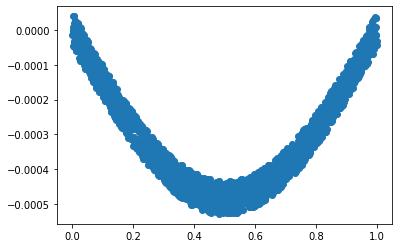

In [9]:
#plot the 1st entry of the dataframe
plt.scatter(fake_dataframe['x'][1],fake_dataframe['y'][1],label=str(fake_dataframe.index[1]))
plt.show()

In [10]:
#with the dataset organized is much easier to split the data.
#https://stackoverflow.com/questions/38250710/how-to-split-data-into-3-sets-train-validation-and-test
#let's take a look at an example 
test_split=0.1 #we will use 10% of the data for testing. 
df = fake_dataframe
train_df, test_df = train_test_split(df, test_size = test_split)

In [11]:
#the training data will be spllited automatically by 80/20 during training using keras framework. 
# no need to split at this stage.
#let's check the array shapes: 
print('Training set: ',train_df.shape)
print('Test set: ',test_df.shape)

train_size = train_df.shape[0]
test_size = test_df.shape[0]

Training set:  (460800, 6)
Test set:  (51200, 6)


C:\Users\luisf\.conda\envs\tf\lib\site-packages\seaborn\distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)


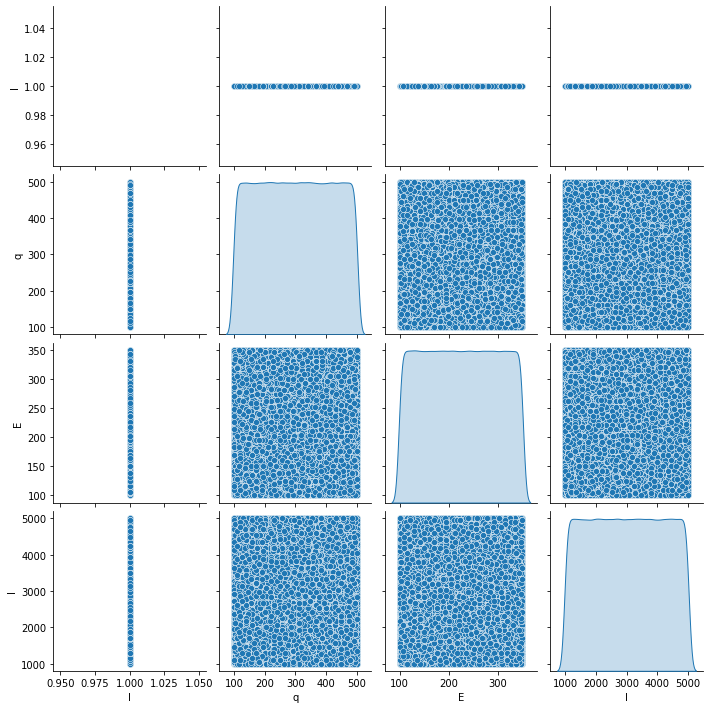

In [12]:
#inspect the training dataset
sns.pairplot(train_df[['l', 'q', 'E', 'I']], diag_kind='kde')

In [13]:
train_df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
l,460800.0,1.000000,0.000000,1.0,1.000000,1.000000,1.000000,1.0
q,460800.0,299.978211,116.907564,100.0,201.265823,297.468354,403.797468,500.0
E,460800.0,224.973622,73.087221,100.0,160.126582,223.417722,286.708861,350.0
I,460800.0,3000.119001,1169.272867,1000.0,2012.658228,3025.316456,4037.974684,5000.0


In [14]:
# follow this tutorial for our data 
# https://www.tensorflow.org/tutorials/keras/regression
# whenever possible, add comments and discussion

In [15]:
# get the max "y" for each entry
df.y.apply(min)
# at this point we could plot very interesting stuff such as ymax distributions on the vars (q,l,E,I)...
# but let's think about that later

0        -0.000781
1        -0.000528
2        -0.000860
3        -0.001380
4        -0.001354
            ...   
511995   -0.003077
511996   -0.000721
511997   -0.001267
511998   -0.001475
511999   -0.001111
Name: y, Length: 512000, dtype: float64

In [16]:
# I have fixed the value of L as 1.0 for now, so I am not using the values of [x,y] as inputs, only the values of y.

In [17]:
# Allocate the features and the labels in different DataFrames.

train_features = train_df.copy()
test_features = test_df.copy()

# train_labels = pd.DataFrame([train_features.pop('l'), train_features.pop('q'), train_features.pop('E'), train_features.pop('I')])
# train_labels = train_labels.T
# test_labels = pd.DataFrame([test_features.pop('l'), test_features.pop('q'), test_features.pop('E'), test_features.pop('I')])
# test_labels = test_labels.T

train_labels = pd.DataFrame([train_features.pop('q'), train_features.pop('E'), train_features.pop('I')])
train_labels = train_labels.T
test_labels = pd.DataFrame([test_features.pop('q'), test_features.pop('E'), test_features.pop('I')])
test_labels = test_labels.T

In [18]:
feature_columns = []

# Will not include the values of x
# x_col = tf.feature_column.numeric_column("x")
# feature_columns.append(x_col)
y_col = tf.feature_column.numeric_column("y")
feature_columns.append(y_col)

my_feature_layer = tf.keras.layers.DenseFeatures(feature_columns)

In [19]:
# Build the model and define its architecture.

In [20]:
inputs = keras.Input(shape=n)

In [21]:
dense = layers.Dense(512, activation="relu")
x = dense(inputs)

In [22]:
x = layers.Dense(512, activation="relu")(x)
outputs = layers.Dense(3)(x)

In [23]:
model = keras.Model(inputs=inputs, outputs=outputs, name="model")

In [24]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 2000)]            0         
_________________________________________________________________
dense (Dense)                (None, 512)               1024512   
_________________________________________________________________
dense_1 (Dense)              (None, 512)               262656    
_________________________________________________________________
dense_2 (Dense)              (None, 3)                 1539      
Total params: 1,288,707
Trainable params: 1,288,707
Non-trainable params: 0
_________________________________________________________________


In [25]:
# Set the hyperparameters

validation_split = 0.2
learning_rate = 0.00005
batch_size = 50
epochs = 20

In [26]:
model.compile(
    loss="mean_squared_error",
    optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
)

# Still need to find what's the best loss function for our model.

In [27]:
# For some reason I had to manually convert the data into tensors.

tf_train_features = tf.constant([train_features['y']], shape=(train_size,n))

tf_train_labels = tf.constant([np.array(train_labels)], shape=(train_size,3))

tf_test_features = tf.constant([test_features['y']], shape=(test_size,n))

tf_test_labels = tf.constant([np.array(test_labels)], shape=(test_size,3))

In [28]:
history = model.fit(tf_train_features, tf_train_labels, batch_size=batch_size, epochs=epochs, validation_split=validation_split)

test_scores = model.evaluate(tf_train_features, tf_train_labels, verbose=2)
print("Test loss:", test_scores)

Epoch 1/20
7373/7373 [==============================] - 98s 13ms/step - loss: 1878812.5000 - val_loss: 761537.7500
Epoch 2/20
7373/7373 [==============================] - 81s 11ms/step - loss: 426560.2188 - val_loss: 310526.0938
Epoch 3/20
7373/7373 [==============================] - 80s 11ms/step - loss: 307573.9688 - val_loss: 306060.5938
Epoch 4/20
7373/7373 [==============================] - 77s 10ms/step - loss: 304649.5000 - val_loss: 303885.0625
Epoch 5/20
7373/7373 [==============================] - 79s 11ms/step - loss: 302386.9062 - val_loss: 301520.6562
Epoch 6/20
7373/7373 [==============================] - 78s 11ms/step - loss: 300058.7500 - val_loss: 299166.9688
Epoch 7/20
7373/7373 [==============================] - 81s 11ms/step - loss: 297633.8750 - val_loss: 296723.2500
Epoch 8/20
7373/7373 [==============================] - 74s 10ms/step - loss: 295168.9062 - val_loss: 294280.2812
Epoch 9/20
7373/7373 [==============================] - 80s 11ms/step - loss: 292967.50

136884.15625


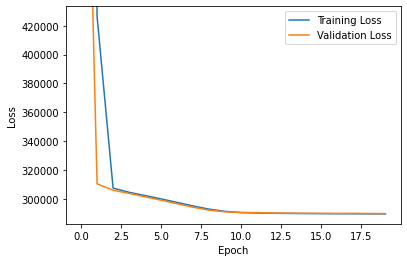

In [29]:
epochs = history.epoch

hist = history.history

plot_the_loss_curve(epochs, hist["loss"], 
                    hist["val_loss"])

In [30]:
tf_test_labels[0:5]

# q; E; I

<tf.Tensor: shape=(5, 3), dtype=float64, numpy=
array([[ 256.96202532,  147.46835443, 2721.51898734],
       [ 383.5443038 ,  258.2278481 , 3481.01265823],
       [ 307.59493671,  324.6835443 , 2012.65822785],
       [ 282.27848101,  220.25316456, 4544.30379747],
       [ 246.83544304,  274.05063291, 4341.7721519 ]])>

In [70]:
guesses = model.predict(tf_test_features)

guesses[0:5]

# q; E; I

array([[ 356.60553,  207.59572, 2748.7307 ],
       [ 298.2799 ,  232.23122, 3217.92   ],
       [ 316.5678 ,  225.58354, 3104.4412 ],
       [ 237.54741,  254.30331, 3594.821  ],
       [ 205.42987,  265.9269 , 3793.3977 ]], dtype=float32)

In [32]:
# relative error (%)

(np.abs(tf_test_labels[0:5] - model.predict(tf_test_features)[0:5]) / tf_test_labels[0:5]) * 100

<tf.Tensor: shape=(5, 3), dtype=float64, numpy=
array([[38.77752144, 40.77306225,  0.99987271],
       [22.23065125, 10.06732305,  7.55793679],
       [ 2.91710697, 30.52202804, 54.24581875],
       [15.84643356, 15.4595507 , 20.89391015],
       [16.77456524,  2.96431445, 12.63019863]])>

In [33]:
error_mat = (np.abs(tf_test_labels - model.predict(tf_test_features)) / tf_test_labels) * 100

error_avg = np.array([0,0,0])
error_avg[0] = np.average(error_mat[:,0])
error_avg[1] = np.average(error_mat[:,1])
error_avg[2] = np.average(error_mat[:,2])

error_avg

# average relative error (%) for [q, E, I]

array([31, 27, 31])

In [34]:
def compare_curves(label, guess, n):

    label = [1, label[0], label[1],label[2]]
    guess = [1, guess[0], guess[1], guess[2]]
    
    x_vec = np.linspace(0, 1, n)
    y_vec = ana_sol(n, label)[1] * 10**3  # [mm]

    points = np.zeros((len(x_vec), 2))

    for i in range(len(x_vec)):
        points[i, 0] = x_vec[i]
        points[i, 1] = y_vec[i]
    
    y_vec_g = ana_sol(n, guess)[1] * 10**3  # [mm]

    points = np.zeros((len(x_vec), 2))

    for i in range(len(x_vec)):
        points[i, 0] = x_vec[i]
        points[i, 1] = y_vec[i]


    plt.plot(x_vec, y_vec, c='g')
    plt.plot(x_vec, y_vec_g, c='r')
    plt.show()

In [35]:
# error_col will contain the average of the relative errors (%) for q, E and I for each guess.

error_col = (error_mat[:,0] + error_mat[:,1] + error_mat[:,2])/3

error_col[0:10]

<tf.Tensor: shape=(10,), dtype=float64, numpy=
array([26.85015213, 13.2853037 , 29.22831792, 17.39996481, 10.78969277,
       20.08064271, 21.69757357, 25.50316364, 21.42376968, 18.10725699])>

In [36]:
np.average(error_col)

30.362678804906032

In [37]:
np.max(error_col)

157.6439849019653

In [38]:
np.min(error_col)

0.4949372266869098

In [39]:
# Relative errors (%) for q, E, I for our best curve.
np.array(error_mat[np.argmin(error_col),:])

array([0.41641041, 0.87824512, 0.19015615])

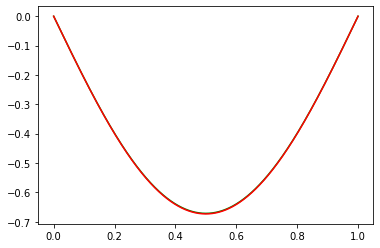

In [40]:
# This is the best guess (the guess which as the minimum average error)
# "True" curve is in green, whereas the "guessed" curve is in red.

min_label = np.array(tf_test_labels[np.argmin(error_col),:])
min_guess = model.predict(tf_test_features)[np.argmin(error_col),:]

compare_curves(min_label, min_guess, n)

In [41]:
# Relative errors (%) for q, E, I for our worst curve.
np.array(error_mat[np.argmax(error_col),:])

array([263.97070312,  87.13165527, 121.82959631])

In [42]:
np.array(tf_test_labels[np.argmax(error_col),:])

array([ 100.        ,  103.16455696, 1050.63291139])

In [43]:
model.predict(tf_test_features)[np.argmax(error_col),:]

array([ 363.9707 ,  193.05354, 2330.6147 ], dtype=float32)

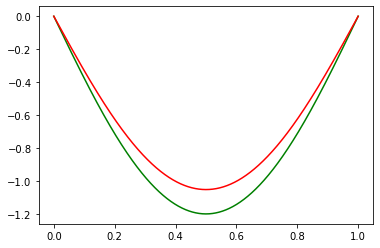

In [44]:
# This is the worst guess (the guess which as the maximum average error)
# "True" curve is in green, whereas the "guessed" curve is in red.

max_label = tf_test_labels[np.argmax(error_col),:]
max_guess = model.predict(tf_test_features)[np.argmax(error_col),:]

compare_curves(max_label, max_guess, n)

The errors for q, E and I (%) are: [4.16735508e-04 2.79770544e+01 2.05265309e+01]


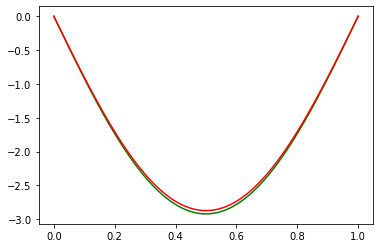

In [45]:
# The curve with less error for q.
i_min_q = np.argmin(error_mat, axis=0)[0]

print('The errors for q, E and I (%) are:', np.array(error_mat[i_min_q,:]))

min_q_label = tf_test_labels[i_min_q,:]
min_q_guess = model.predict(tf_test_features)[i_min_q ,:]

compare_curves(min_q_label, min_q_guess, n)

The errors for q, E and I (%) are: [5.44344646e+01 1.33021597e-04 5.92675550e+01]


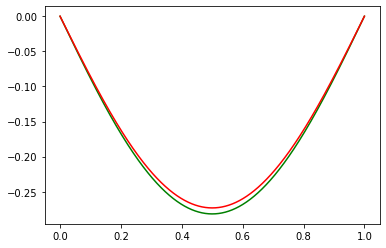

In [46]:
# The curve with less error for E.
i_min_E = np.argmin(error_mat, axis=0)[1]

print('The errors for q, E and I (%) are:', np.array(error_mat[i_min_E,:]))

min_E_label = tf_test_labels[i_min_E,:]
min_E_guess = model.predict(tf_test_features)[i_min_E ,:]

compare_curves(min_E_label, min_E_guess, n)

The errors for q, E and I (%) are: [2.12276218e+01 2.14191014e+01 7.28042671e-05]


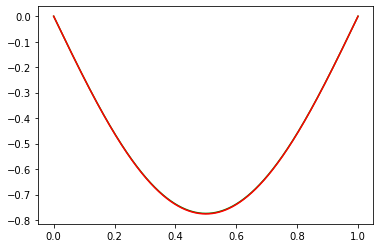

In [47]:
# The curve with less error for I.
i_min_I = np.argmin(error_mat, axis=0)[2]

print('The errors for q, E and I (%) are:', np.array(error_mat[i_min_I,:]))

min_I_label = tf_test_labels[i_min_I,:]
min_I_guess = model.predict(tf_test_features)[i_min_I ,:]

compare_curves(min_I_label, min_I_guess, n)

The errors for q, E and I (%) are: [263.97070312  87.13165527 121.82959631]


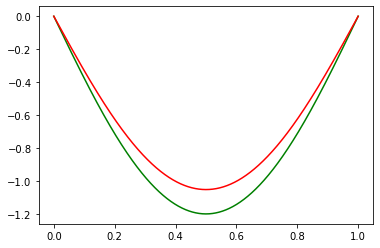

In [48]:
# The curve with more error for q.
i_min_q = np.argmax(error_mat, axis=0)[0]

print('The errors for q, E and I (%) are:', np.array(error_mat[i_min_q,:]))

min_q_label = tf_test_labels[i_min_q,:]
min_q_guess = model.predict(tf_test_features)[i_min_q ,:]

compare_curves(min_q_label, min_q_guess, n)

The errors for q, E and I (%) are: [106.50883484 165.53659058  20.22623717]


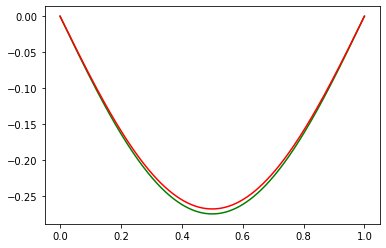

In [49]:
# The curve with more error for E.
i_min_E = np.argmax(error_mat, axis=0)[1]

print('The errors for q, E and I (%) are:', np.array(error_mat[i_min_E,:]))

min_E_label = tf_test_labels[i_min_E,:]
min_E_guess = model.predict(tf_test_features)[i_min_E ,:]

compare_curves(min_E_label, min_E_guess, n)

The errors for q, E and I (%) are: [140.80867004  26.36029351 257.39724121]


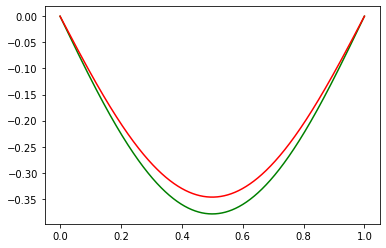

In [50]:
# The curve with more error for I.
i_min_I = np.argmax(error_mat, axis=0)[2]

print('The errors for q, E and I (%) are:', np.array(error_mat[i_min_I,:]))

min_I_label = tf_test_labels[i_min_I,:]
min_I_guess = model.predict(tf_test_features)[i_min_I ,:]

compare_curves(min_I_label, min_I_guess, n)

In [51]:
# We will use the difference between min_y_guessed and min_y_true to evaluate the quality of the curves.

guess_curves = np.zeros([np.size(guesses, 0), n])
true_curves = np.zeros([np.size(guesses, 0), n])

for i in range(np.size(guesses, 0)):
    parameter_list = [1, guesses[i, 0], guesses[i,1], guesses[i,2]]
    guess_curves[i] = ana_sol(n, parameter_list)[1]
    
for i in range(np.size(guesses, 0)):
    true_parameter_list = [1, tf_test_labels[i, 0], tf_test_labels[i,1], tf_test_labels[i,2]]
    true_curves[i] = ana_sol(n, true_parameter_list)[1]
    
delta_y = np.abs(np.min(guess_curves, axis = 1) - np.min(true_curves, axis = 1))

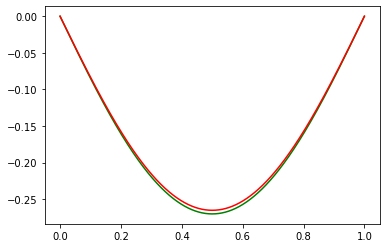

In [52]:
i_min_delta = np.argmin(delta_y)
compare_curves(tf_test_labels[i_min_delta,:], model.predict(tf_test_features)[i_min_delta ,:], n)

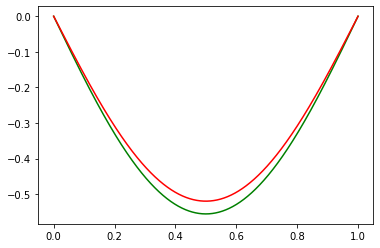

In [53]:
i_max_delta = np.argmax(delta_y)
compare_curves(tf_test_labels[i_max_delta,:], model.predict(tf_test_features)[i_max_delta ,:], n)

In [54]:
# It's probably even better to use the relative error for the minimum value of y to evaluate the quality of the curves.
    
rel_err_y = np.abs(delta_y / np.min(true_curves, axis = 1)) * 100     # in %

In [55]:
np.average(rel_err_y)

4.50213800936155

In [56]:
np.max(rel_err_y)

7.8632806024474675

In [57]:
np.min(rel_err_y)

1.833513872399358

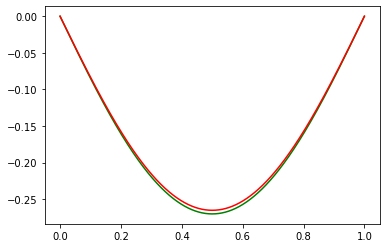

In [58]:
# Best curve

i_min_err = np.argmin(rel_err_y)
compare_curves(tf_test_labels[i_min_err,:], model.predict(tf_test_features)[i_min_err, :], n)

In [59]:
print(guesses[i_min_err])
print(np.array(tf_test_labels[i_min_err]))
print(np.array(error_mat[i_min_err, :]))
print(float(error_col[i_min_err]))
print(rel_err_y[i_min_err])

[ 205.42987  265.9269  3793.3977 ]
[ 246.83544304  274.05063291 4341.7721519 ]
[16.77456524  2.96431445 12.63019863]
10.789692773674995
1.833513872399358


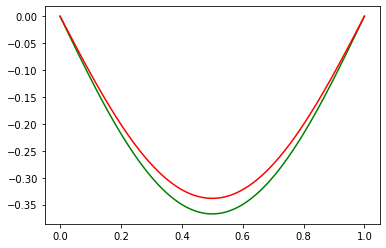

In [60]:
# Worst curve

i_max_err = np.argmax(rel_err_y)
compare_curves(tf_test_labels[i_max_err,:], model.predict(tf_test_features)[i_max_err ,:], n)

In [61]:
print(guesses[i_max_err])
print(np.array(tf_test_labels[i_max_err]))
print(np.array(error_mat[i_max_err, :]))
print(float(error_col[i_max_err]))
print(rel_err_y[i_max_err])

[ 237.54741  254.30331 3594.821  ]
[ 282.27848101  220.25316456 4544.30379747]
[15.84643356 15.4595507  20.89391015]
17.399964806719016
7.8632806024474675


In [62]:
# 07/08/2021

# There is no point in trying to guess L in this case, as there is only one value for it.

# Even for multiple values of L, I think that it doesn't make sense to have [x, y] as inputs and at the same time try to 
# guess L, at least in the way I was innitially doing, because, (as the x values are linnearly spaced and allways the same
# for each L), we could easily check the max value of x and get L from that, without any need for a machine learning method.

In [63]:
# 07/08/2021

# Need to improve the way I feed the data to the model (had to extract it from DataFrames and convert the arrays to tensors...)

# Will try to figure out the best loss function, the best architecture for the model,
# tune the hyperparameters and try to get good results.

In [64]:
# 12/09/2021

# I am now only trying to find 3 parameters: E, q and I, as L was set to 1.0.

# After some tunning and experimenting, I'm still not able to say if the problem is with the architecture
# of the model being still too simple, if the problem is with the loss function or if it has to due with
# the lack of normalization of the features. I've noticed that the model is very bad at guessing
# the values for I, which are very small.

In [65]:
# 18/09/2021

# Adjusted the units of q, E and I. This way the values of the loss function don't get too high, they were
# often turning into NaN when I tryed to adjust the model or increase the number of [x,y] inputs.
# This way it is also easier to read the resuts.

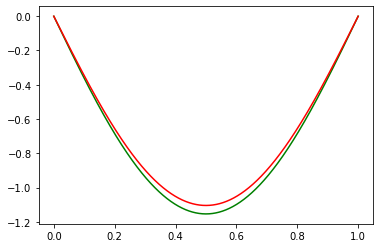

In [66]:
# 28/09/2021

# Tried out the model with 64000 combinations. Running time around 3 minutes.
# The average error hasn't gone down, but the curves are apperently much better.
# Even the "worst curve", which for 
# q = 100; E = 112.82051282; I = 1000 guessed
# q = 380.58313; E = 194.59201; I = 2305.1836,
# with an average relative error of 161.2%,
# is quite similar to the true curve, as we can see below.

compare_curves([100, 112.82051282, 1000], [380.58313, 194.59201, 2305.1836], n)

In [67]:
# 05/10/2021

# Found two interesting curves in one of my runs (Curve 1 and Curve 2 below). Curve 1 has an average relative error
# for the guesses of q, E and I around 27,5% and Curve 2 has an average relative error for the guesses of these values
# of around 20.7% but Curve 1 is my most accurate curve and Curve 2 the least accurate curve if we check the
# relative errors for the minimum values of y:

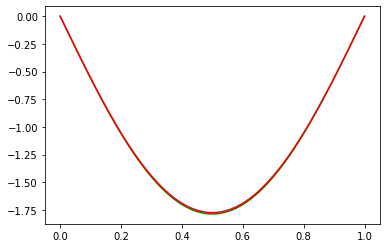

In [68]:
# Curve 1:

# True label values: q = 366.6666; E = 221.7948; I = 1205.1282
# Guessed values: q = 399.8565; E = 164.7294; I = 1781.4537
# Reletive errors: r.e_q = 9.05%; r.e_E = 25.73%; r.e_I = 47.82%
# Average relative error: 27.53%

# Relative error for delta_min_y: 0.67%

compare_curves([366.6666, 221.7948, 1205.1282], [399.8565, 164.7294, 1781.4537], n)

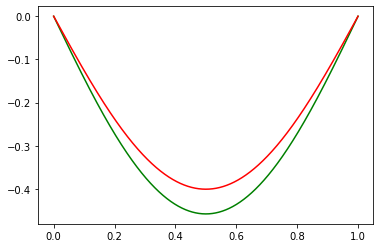

In [69]:
# Curve 2:

# True label values: q = 223.07692; E = 260.25641; I = 2435.8974
# Guessed values: q = 261.46088; E = 248.53142; I = 3416.9976 ]
# Reletive errors: r.e_q = 17.21%; r.e_E = 4.51%; r.e_I = 40.28%]
# Average relative error: 20.66%

# Relative error for delta_min_y: 12.50%

compare_curves([223.07692, 260.25641, 2435.8974], [261.46088, 248.53142, 3416.9976], n)